In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import astropy.units as u
import splat.empirical as spe
import splat
#plt.style.use('dark_background')

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


Purpose: compare various luminosity functions

In [2]:
%matplotlib inline

In [3]:
import popsims

In [4]:
baraffe=popsims.make_systems(model='baraffe2003', bfraction=0.2)
saumon=popsims.make_systems(model='saumon2008', bfraction=0.2)
sonora=popsims.make_systems(model='marley2019', bfraction=0.2)
phillips=popsims.make_systems(model='phillips2020', bfraction=0.2)
burrows=popsims.make_systems(model='burrows2001', bfraction=0.2)

In [5]:
from astropy.io import ascii

In [6]:
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
dntb=ascii.read('/users/caganze/research/wisps/data/daniellalf.txt').to_pandas()

In [7]:
def splat_mag_to_spt(mag):
    grid=np.arange(17, 39)
    rel=spe.typeToMag(grid, 'MKO_J',reference='dupuy2012')[0]
    vals= np.polyval(rel, grid)
    spt_sorted_idx=np.argsort(vals)
    return np.interp(mag, vals[spt_sorted_idx], grid[spt_sorted_idx])
       

In [8]:
klf['tfm']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)

In [9]:
klf['spt']=klf.tfm.apply(wispsim.splat_teff_to_spt).apply(round)

In [10]:
klf=klf.applymap(float)

In [11]:
dntb['spt']=dntb.M_J.apply(splat_mag_to_spt)

In [12]:
def ryan_lf(J):
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

    
def custom_histogram(things, grid, binsize):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+binsize)]))
    return np.array(n)

In [13]:
jgrid=np.arange(10, 18, .5)
teffgrid=np.arange(50, 4000, 150)

In [14]:
#the last point is a lower limit
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [15]:
1950+150

2100

In [16]:
binedges= np.append(kirkpatrick2020LF['bin_center']-75,
                    kirkpatrick2020LF['bin_center'][-1]+75)
                    
binedges

array([ 450,  600,  750,  900, 1050, 1200, 1350, 1500, 1650, 1800, 1950,
       2100])

In [17]:
kirkpatrick2020LF

{'bin_center': array([ 525,  675,  825,  975, 1125, 1275, 1425, 1575, 1725, 1875, 2025]),
 'values': array([4.24, 2.8 , 1.99, 1.72, 1.11, 1.95, 0.94, 0.81, 0.78, 0.5 , 0.72]),
 'unc': array([0.7 , 0.37, 0.32, 0.3 , 0.25, 0.3 , 0.22, 0.2 , 0.2 , 0.17, 0.18])}

In [18]:
def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]+75)
    #bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    #print (binedges[0], binedges[-1])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    res=preds*np.nanmedian(scale), [np.nanmedian(scale), np.nanstd(scale), \
                                     np.sum(preds*np.nanmedian(scale))]
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #ax.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return res

(array([1.047852e+06, 4.601700e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 3.000000e+00, 4.900000e+01, 1.463000e+03,
        9.490000e+02, 5.100000e+01]),
 array([  229.78423811,  2204.07573666,  4178.36723521,  6152.65873376,
         8126.95023231, 10101.24173086, 12075.53322941, 14049.82472796,
        16024.11622651, 17998.40772506, 19972.69922361]),
 [<matplotlib.patches.Polygon at 0x7ff0de571eb0>])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


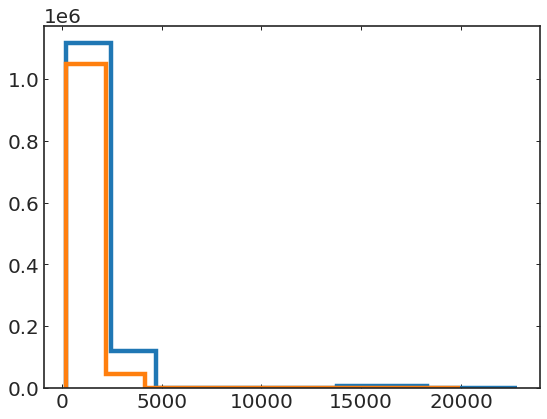

In [19]:
fig, ax=plt.subplots()
plt.hist(baraffe['temperature'], histtype='step', lw=4)
plt.hist(saumon['temperature'], histtype='step', lw=4)

In [20]:
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

In [21]:
teffs_bar=baraffe['temperature']
teffs_saumon=saumon['temperature']
teffs_sonora=sonora['temperature']
teffs_phil=phillips['temperature']
teffs_burr=burrows['temperature']

#normteff_bar = 0.63*(10**-3)/ len(teffs_bar[np.logical_and(teffs_bar>=1650, teffs_bar <=1800)])
#normteff_saumon = 0.63*(10**-3)/ len(teffs_saumon[np.logical_and(teffs_saumon>=1650, teffs_saumon <=1800)])
#normteff_sonora= 0.63*(10**-3)/ len(teffs_sonora[np.logical_and(teffs_sonora>=1650, teffs_sonora <=1800)])
#normteff_phil=0.63*(10**-3)/ len(teffs_phil[np.logical_and(teffs_phil>=1650, teffs_phil <=1800)])
#jmags=wisps.drop_nan(spe.typeToMag(SIMULATED_DIST['spts'][0], '2MASS J')[0])
#jnorm=6.570*(10**-3)/len(jmags[np.logical_and(jmags>=10.25-.25, jmags <=10.25+.25)])

In [22]:
 scale_lf_teff(teffs_bar)

(array([0.0039046 , 0.0029357 , 0.00230553, 0.00179828, 0.00140731,
        0.00113068, 0.00090943, 0.00070891, 0.00060338, 0.00058993,
        0.00060258]),
 [1.951939004389072e-08, 1.1437396966452898e-09, 0.016896335371012598])

In [23]:
#s0

In [24]:
#sem_emp_phi_j=custom_histogram(jmags, jgrid, .5)*jnorm
baraffe_phi_teff, s0= scale_lf_teff(teffs_bar)
saumon_phi_teff, s1=scale_lf_teff(teffs_saumon)
sonora_phi_teff, s2=scale_lf_teff(teffs_sonora)
phil_phi_teff, s3=scale_lf_teff(teffs_phil)
burr_phi_teff, s4=scale_lf_teff(teffs_burr)

In [25]:
SCALE_FACTORS={'baraffe2003': s0, 'saumon2008': s1, 
               'marley2019': s2, 'phillips2020': s3, 
              'burrows2001':s4}

In [26]:
SCALE_FACTORS

{'baraffe2003': [1.953420902384258e-08,
  1.155015382312814e-09,
  0.016909162946800567],
 'saumon2008': [1.9853596612288464e-08,
  1.1582364396163826e-09,
  0.017004228280089434],
 'marley2019': [1.9968596916159507e-08,
  1.1712293081888756e-09,
  0.01677855365301228],
 'phillips2020': [2.0193746700185824e-08,
  1.2032045840829727e-09,
  0.01640436993814925],
 'burrows2001': [2.0129339658385164e-08,
  1.2066124272587738e-09,
  0.016652600112588876]}

In [27]:
import pickle
with open(wisps.OUTPUT_FILES+'/lf_scales.pkl', 'wb') as file:
   pickle.dump(SCALE_FACTORS,file)

In [28]:
#count how many things are in the masses of 0.1 and stuff and compare to 0.005 pc to 0.0037 pc^3

#2 things doing this 

#teff-> bolometric correction -> simulated luminosity ---> magnitude

#try will best's 2018 relation 
#and that we dont't complete samples for some magnitudes 
#compare to bochanski's measurement
#look at the scale factors between those two plots you might you want

#you should be plotting the fits that are 
#invert relations

#invert

#binary fraction (how many)
#binary fraction random 20% 
#binary mass ratio from a distribution from splat (allen et al. from splat)
#the secondary have a magnitude 
#the bianay 
#mag of the system by combining the flux
#hst magnitude of the secondary by adding the 
#adding the
#everything is laid out in burgasser 2007
#educational exercise to find thre number of stars and brown dwarfs


In [29]:
import seaborn as sns
sns.set_palette(sns.color_palette('Paired'))

In [30]:
#plt.style.use('dark_background')

[1 0 0 0 0 0 0 0 0 0 0]


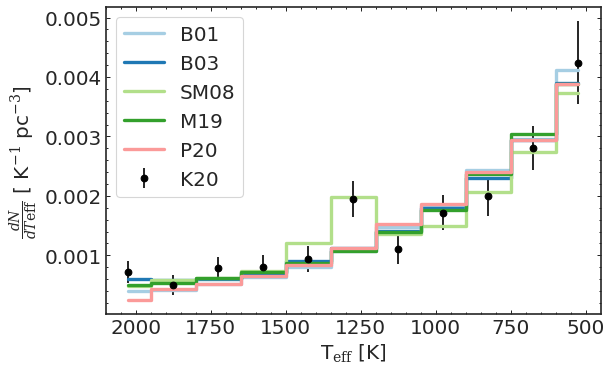

In [31]:
fig, ax1=plt.subplots(figsize=(8, 5), ncols=1)
#ax.step(jgrid, sem_emp_phi_j, color='#0074D9', label='Simulated')
#ax.step(jgrid,  ryan_lf(jgrid), color='#FF4136', label='RyanJr2017')
#ax.errorbar(dntb.M_J, dntb.Density*(10**-3), fmt='o', c='k', label='BG2019')

#ax.set_xlabel('J', fontsize=18)
#ax.set_ylabel(r'LF [pc$^{-3}$ mag$^{-1} $]', fontsize=18)
#ax.minorticks_on()
#ax.legend(fontsize=18)
#ax.set_xlim([10, 16])
#ax.set_ylim([0., 0.005])
ax1.step(kirkpatrick2020LF['bin_center'], burr_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], baraffe_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], saumon_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], sonora_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], phil_phi_teff,  where='mid', linewidth=3)
lolims=np.zeros(len(kirkpatrick2020LF['bin_center'])).astype(int)
lolims[0]=int(1)

print (lolims)
ax1.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
             yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3),
             fmt='o', color='k')

#for index, row in klf.iterrows():
#    if row.lf==0.0:
#        pass
#    elif row.lfunc==0.0:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3), yerr=0.0005, color='#B10DC9', fmt='o',lolims=True, ls='none')
#    else:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3),  yerr=row.lfunc*(10**-3), color='#B10DC9', fmt='o')
ax1.set_xlabel(r'T$_\mathrm{eff}$ [K]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dT\mathrm{eff}}$ [ K$^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['B01', 'B03',  'SM08',  'M19',  'P20',  'K20'])
ax1.set_xlim([2100, 450.])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_teffs_plus_binaries.pdf',bbox_inches='tight',  facecolor='white', transparent=False)

In [32]:
#ghj

In [33]:
import splat.empirical as spe

In [34]:
#

In [35]:
#ms=get_mko_mag(baraffe['system_spts'].flatten())

In [36]:
#plt.scatter(baraffe['system_spts'].flatten(), ms,  s=1)


In [37]:
#js_saumon=wisps.absolute_magnitude_jh(np.sort(saumon['system_spts'].flatten()))[0]
#js_bar=wisps.absolute_magnitude_jh(np.sort( baraffe['system_spts'].flatten()))[0]
#js_sonora=wisps.absolute_magnitude_jh(np.sort( sonora['system_spts'].flatten()))[0]
#js_phil=wisps.absolute_magnitude_jh(np.sort( phillips['system_spts'].flatten()))[0]

js_saumon=saumon['abs_2MASS_J'].values.flatten()
js_bar=baraffe['abs_2MASS_J'].values.flatten()
js_sonora=sonora['abs_2MASS_J'].values.flatten()
js_phil=phillips['abs_2MASS_J'].values.flatten()
js_burr=burrows['abs_2MASS_J'].values.flatten()

In [38]:
CRUZ={"J":np.array([10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75]),
      "lf": np.array([2.38, 1.66, 1.16, 0.83, 0.50, 0.58, 0.50, 0.66, 0.33]),
     'er':np.array([0.64, 0.37, 0.31, 0.26, 0.20, 0.22, 0.20, 0.23, 0.17])}

DNLF={"J": dntb.M_J.values, 'lf': dntb.Density.values, 
     "er":[[1.39, 0.39, 0.29, 0.20, 0.18, 0.15, 0.41, 0.16, 0.15], 
           [1.62, 4.14, 0.31, 0.23, 0.20, 0.18, 1.65, 0.18, 0.18]]}

In [39]:
DNLF['er_tot']=np.nanmedian(
    DNLF['er'], axis=0)

In [40]:
DNLF['J'][np.argmin(DNLF['er_tot'])]

12.25

In [41]:
DNLF['lf'][np.argmin(DNLF['er_tot'])]

1.1

In [42]:
mask=np.logical_and(DNLF['J'] < 14.5, DNLF['J'] > 10.5)

def scale_lf_jmag(js):
    #mask=np.logical_and(DNLF['J'] <= 15.5, DNLF['J'] >= 10.)
    jgrid=np.array(DNLF['J'])[mask]
    print (jgrid)
    obs=np.array(DNLF['lf'])[mask]
    unc=np.array(DNLF['er_tot'])[mask]
    binedges= np.append(jgrid-0.25, jgrid[-1]+0.25)
    #binedges=jgrid
    print (binedges)
    preds=np.histogram(js, bins=binedges, normed=False)[0]
    
   
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
  
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    res=preds*np.nanmedian(scale), [np.nanmedian(scale), np.nanstd(scale), \
                                     np.sum(preds*np.nanmedian(scale))]
    

    #scale=np.nansum((obs*preds)/(unc**2))/np.nansum(((preds**2)/(unc**2)))
    #bools=np.logical_and(js > 12., js< 12.5)
    #print (res)
    #scale= 
    return res[0]
    #return 1.1*preds/len(js[bools])

In [43]:
baraffe_phi_j=scale_lf_jmag(js_bar)#*(10**-3)
saumon_phi_j=scale_lf_jmag(js_saumon)#*(10**-3)
sonora_phi_j=scale_lf_jmag(js_sonora)#*(10**-3)
phil_phi_j=scale_lf_jmag(js_phil)#*(10**-3)\
burr_phi_j=scale_lf_jmag(js_burr)

[10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[10.5 11.  11.5 12.  12.5 13.  13.5 14. ]
[10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[10.5 11.  11.5 12.  12.5 13.  13.5 14. ]
[10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[10.5 11.  11.5 12.  12.5 13.  13.5 14. ]
[10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[10.5 11.  11.5 12.  12.5 13.  13.5 14. ]
[10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[10.5 11.  11.5 12.  12.5 13.  13.5 14. ]


In [44]:
jgrid=np.array(DNLF['J'])[mask]

In [45]:
len(jgrid), len(saumon_phi_j)

(7, 7)

In [46]:
#DNLF['J'][bools]

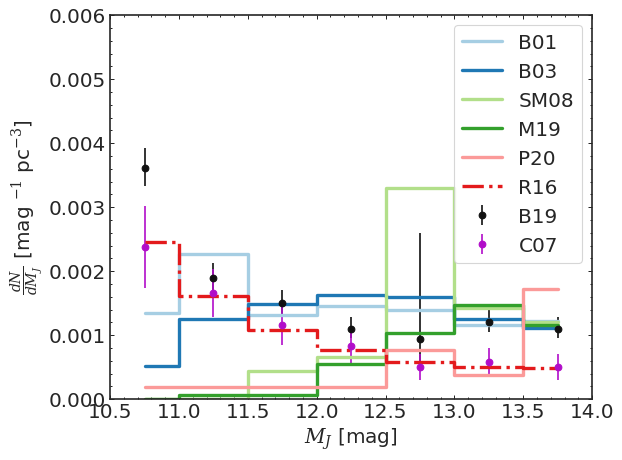

In [47]:
fig, ax1=plt.subplots(figsize=(8, 6), ncols=1)
#plt.step(jgrid, ryan_lf(jgrid))

plt.step(jgrid, burr_phi_j, linewidth=3, where='mid')
plt.step(jgrid, baraffe_phi_j, linewidth=3, where='mid')
plt.step(jgrid, saumon_phi_j, linewidth=3, where='mid')
plt.step(jgrid, sonora_phi_j, linewidth=3, where='mid')
plt.step(jgrid,phil_phi_j, linewidth=3, where='mid')
plt.step(jgrid, ryan_lf(jgrid), \
          linewidth=3, where='mid', linestyle='-.')

#plt.fill_between(jgrid, np.array(baraffe_phi_j)-0.00016, np.array(baraffe_phi_j)+0.00018,  step="pre")

plt.errorbar(DNLF['J'], DNLF['lf']*0.001, yerr=np.array(DNLF['er'])*0.001,color='#111111', fmt='o')
plt.errorbar(CRUZ['J'], np.array(CRUZ['lf'])*0.001, yerr=np.array(CRUZ['er'])*0.001,color='#B10DC9', fmt='o')


ax1.set_xlabel(r'$M_J$ [mag]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dM_J}$ [mag $^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=[ 'B01', 'B03', 'SM08', 'M19', 'P20', 'R16', 'B19', 
                               'C07'])
plt.tight_layout()
plt.xlim(10.5, 14.)
plt.ylim([0.00, 0.006])
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_js_plus_binaries_teff.pdf',  bbox_inches='tight')

In [48]:
#other diagnostics
#plt.hist(burrows['system_'])

In [49]:
ydf=pd.read_pickle('/users/caganze/y_standards.pkl')

In [50]:
ydf[ydf.spt=='Y0.0'].spec.values[0].flux

<Quantity [ 1.32856353e-18,  9.85575134e-19,  6.69732679e-19,
            4.16216842e-19,  2.96913731e-19,  2.53695329e-19,
            1.37803474e-19,  2.16473557e-19,  9.73708785e-20,
            2.33206237e-19,  2.41318645e-19,  1.98920847e-19,
           -1.36325070e-20,  2.54795122e-20, -2.30349185e-20,
           -4.58408495e-20,  3.38777157e-19,  3.95284314e-19,
            1.55983070e-19,  2.33259915e-19,  6.52956791e-19,
            9.01209772e-19,  1.11815437e-18,  1.46171102e-18,
            1.81982727e-18,  2.53406172e-18,  3.21444078e-18,
            3.88965843e-18,  4.75153680e-18,  6.00811483e-18,
            7.27785294e-18,  8.75843970e-18,  1.01089599e-17,
            1.12026998e-17,  1.21881182e-17,  1.33842789e-17,
            1.30093027e-17,  1.13356724e-17,  9.31107367e-18,
            7.46802246e-18,  5.78816846e-18,  4.34509127e-18,
            3.32058731e-18,  2.49312337e-18,  1.72030311e-18,
            1.16032805e-18,  7.81519795e-19,  6.04750679e-19,
        

In [51]:
ydf.name

0    WISE1738+2732
1    WISE0350-5658
Name: name, dtype: object